In [1]:
%pip install livelossplot > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import glob
import cv2
import tqdm
import functools

from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from livelossplot import PlotLosses

In [3]:
data_path ="/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
print(os.listdir(data_path))

['benign', 'normal', 'malignant']


## Loading Data

### Dataset Object

In [4]:
class_weight = {}
total = 0.0
images = glob.glob(os.path.join(data_path, "*", "*"))
for m in filter(lambda x: "mask" in x, images):
    mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255
    mask = mask.astype(np.int64)
    unique, counts = np.unique(mask, return_counts=True)
    for c, count in zip(unique.tolist(), counts.tolist()):
        class_weight[c] = class_weight.get(c, 0.0) + float(count)
        total += float(count)
for c in class_weight.keys():
    class_weight[c] = total / class_weight[c]

print(class_weight)

{0: 1.0790920820574548, 1: 13.643490650221725}


In [5]:
class BiologyDataset(Dataset):
    def __init__(self, root: str, class_weight={}, transforms=None):
        self.root = root
        self.transforms   = transforms
        self.class_weight = class_weight

        pair = {}
        for img in glob.glob(os.path.join(root, "*", "*")):        
            if (m:=re.search(r'([^/]+?)(?:_mask.*)?\.png$', img)):
                img_id = m.group(1)
                if img_id in pair:
                    if "mask" in img:
                        pair[img_id][1].append(img)
                else:
                    if "mask" in img:
                        path = os.path.join(os.path.dirname(img), img_id + ".png")
                        if os.path.exists(path):
                            pair[img_id] = (path, [img])
                    else:
                        pair[img_id] = (img, [])

        self.images   = list(pair.values())
        self.category = [os.path.dirname(p).split("/")[-1] for p, _ in self.images]

    def __getitem__(self, idx):
        img_path, mask_paths = self.images[idx]
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        masks = []
        for m in mask_paths:
            mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
            masks.append(np.array(mask, dtype=np.uint8))
        mask = np.max(masks, axis=0)
            
        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img  = transformed["image"]
            mask = transformed["mask"]

        weights = torch.empty(mask.size(), dtype=torch.float64)
        for c in np.unique(mask):
            weights[mask == c] = self.class_weight.get(c, 1.0)
        
        return img, mask, weights

    def __len__(self):
        return len(self.images)

In [6]:
def resize_input(x, size, interpolation, **kwargs):
    return cv2.resize(x, size, interpolation=interpolation)

def process_mask(mask, **kwargs):
    return (mask / 255).astype(np.int64)

def get_train_transforms(image_size, mask_size):
    resize_image = functools.partial(resize_input, size=image_size, interpolation=cv2.INTER_CUBIC)
    resize_mask  = functools.partial(resize_input, size=mask_size, interpolation=cv2.INTER_NEAREST)
        
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ElasticTransform(
            alpha=120,
            sigma=120 * 0.05,
            interpolation=cv2.INTER_CUBIC,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.5,
        ),
        A.Affine(
            scale=(0.8, 1.2),
            rotate=(-30, 30),
            interpolation=cv2.INTER_CUBIC,
            mask_interpolation=cv2.INTER_NEAREST,
            fill=0,
            fill_mask=0,
            p=0.5
        ),
        A.Lambda(image=resize_image, mask=resize_mask),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), p=0.5),
        A.OneOf([
            A.GaussNoise(),
            A.GaussianBlur(blur_limit=3),
        ], p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.225, 0.225, 0.225)),
        A.Lambda(mask=process_mask),
        ToTensorV2(),
    ])

def get_val_transforms(image_size, mask_size):
    resize_image = functools.partial(resize_input, size=image_size, interpolation=cv2.INTER_CUBIC)
    resize_mask  = functools.partial(resize_input, size=mask_size, interpolation=cv2.INTER_NEAREST)
        
    return A.Compose([
        A.Lambda(image=resize_image, mask=resize_mask),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.225, 0.225, 0.225)),
        A.Lambda(mask=process_mask),
        ToTensorV2(),
    ])

### Train, Validation, Test Split

In [7]:
dataset = BiologyDataset(data_path)

idx = range(len(dataset))

train_idx, test_idx, train_cat, _ = train_test_split(idx, dataset.category, test_size=0.2, stratify=dataset.category)
train_idx, val_idx  = train_test_split(train_idx, test_size=0.2, stratify=train_cat)

In [8]:
train_dataset = Subset(BiologyDataset(data_path, class_weight=class_weight, transforms=get_train_transforms((572, 572), (388, 388))), train_idx)
val_dataset   = Subset(BiologyDataset(data_path, class_weight=class_weight, transforms=get_val_transforms((572, 572), (388, 388))), val_idx)
test_dataset  = Subset(BiologyDataset(data_path, class_weight=class_weight, transforms=get_val_transforms((572, 572), (388, 388))), test_idx)

### Dataloader

In [9]:
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## UNet Model

### Model Architecture

In [10]:
class DoubleConv(nn.Module):
    def __init__ (self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=0)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=0)
        self.relu2 = nn.ReLU(inplace=True)

        torch.nn.init.normal_(self.conv1.weight, mean=0, std=np.sqrt(2 / (3 * 3 * in_channels)))
        torch.nn.init.normal_(self.conv2.weight, mean=0, std=np.sqrt(2 / (3 * 3 * out_channels)))

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(Down,self).__init__()
        self.down = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels,out_channels)
        
    def forward(self,x):
        x = self.down(x)
        x = self.conv(x)
        return x
    
class Up(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Up,self).__init__()
        self.up = nn.ConvTranspose2d(in_channels,in_channels//2,kernel_size=2,stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
        
    def forward(self,x,res):
        x = self.up(x)
        res = v2.CenterCrop(x.size()[-2:])(res)
        x = torch.cat([x,res],dim=1)
        x = self.conv(x)
        return x
    

In [11]:
class UNet(nn.Module):
    def __init__(self,n_channels=1,n_classes=2):
        super(UNet,self).__init__()
        
        # Contracting path (encoder)
        self.inc   = DoubleConv(n_channels,64)
        self.down1 = Down(64,128)
        self.down2 = Down(128,256)
        self.down3 = Down(256,512)
        self.down4 = Down(512,1024)

        # Expansive path (decoder)
        self.up1 = Up(1024,512)
        self.up2 = Up(512,256)
        self.up3 = Up(256,128)
        self.up4 = Up(128,64)

        #Output layer
        self.outc = nn.Conv2d(64,n_classes,kernel_size=1)

    def forward(self,x):
        # contracting path 
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        #expansive path 
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
            
        # Output
        output = self.outc(x)
        return output   

### UNet Criterion

In [12]:
class UNetLoss(nn.Module):
    def __init__(self):
        super(UNetLoss, self).__init__()

    def forward(self, outputs, targets, weights=None):

        outputs = F.softmax(outputs, dim=1)
        outputs = outputs.view(*outputs.size()[:2], -1)
        targets = targets.view(*targets.size()[:1], -1)

        loss = F.cross_entropy(outputs, targets, reduction="none")
        
        if weights is not None:
            loss *= weights.view(*weights.size()[:1], -1)

        loss = loss.sum(axis=0).mean()
        
        return loss

## Model Training

### Training Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks, weights in tqdm.tqdm(iter(train_loader), "Training"):
        images, masks, weights = images.to(device), masks.to(device), weights.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks, weights)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks, weights in tqdm.tqdm(iter(val_loader), "Validation"):
            images, masks, weights = images.to(device), masks.to(device), weights.to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks, weights)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

### Training Loop

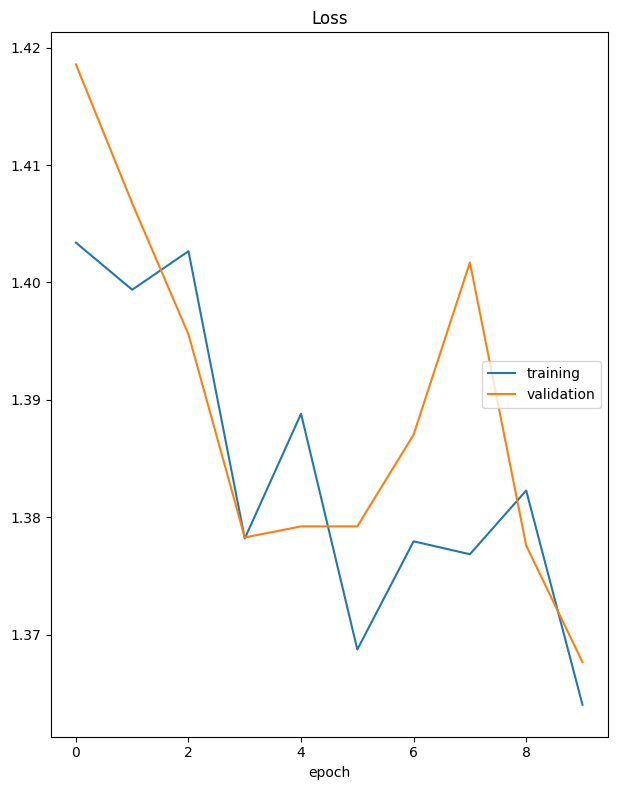

Loss
	training         	 (min:    1.364, max:    1.403, cur:    1.364)
	validation       	 (min:    1.368, max:    1.419, cur:    1.368)


In [14]:
plotlosses = PlotLosses()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = UNet(n_channels=1, n_classes=2).to(device)

criterion = UNetLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-5, momentum=0.99, weight_decay=1e-10)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

best_val_loss = float('inf')

for epoch in range(10):
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    scheduler.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_unet_model.pth')

    plotlosses.update({'loss': train_loss, 'val_loss': val_loss})
    plotlosses.send()

## Model Evaluation

### Loading best model

In [15]:
model = UNet(n_channels=1, n_classes=2).to(device)
model.load_state_dict(torch.load('best_unet_model.pth'))

<All keys matched successfully>

### Utility Function

In [16]:
from sklearn.metrics import rand_score

def restore(images, mean=0.5, std=0.225):
    images = images.detach().cpu().numpy() * np.array(std) + np.array(mean)
    images.resize((images.shape[0], *images.shape[-2:]))
    return images

def output_to_mask(images):
    images = torch.argmax(images, dim=1).to(torch.uint8)
    return images.cpu()

def pixel_error(ground_truth, prediction):
  if ground_truth.size() != prediction.size():
    raise ValueError("Input masks must have the same shape.")

  misclassified_pixels = (ground_truth != prediction).sum()
  total_pixels = ground_truth.numel()
  error = misclassified_pixels / total_pixels

  return error

def rand_error(ground_truth, prediction):
  if ground_truth.size() != prediction.size():
    raise ValueError("Input masks must have the same shape.")

  error = 1.0 - rand_score(ground_truth.view(-1).numpy(), prediction.view(-1).numpy())

  return error

def evaluate_error(model, data):
    model.to(device)
    
    instance, masks, _ = data
    instance = instance.to(device)
    
    output = model(instance)
    output = output_to_mask(output)
    
    masks = masks.view(output.size())

    pixel_err, rand_err = 0.0, 0.0

    for i in range(len(instance)):
        pixel_err += pixel_error(masks[i], output[i])
        rand_err  += rand_error(masks[i], output[i])

    return pixel_err / len(instance), rand_err / len(instance)

def plot_output(model, data):
    model.to(device)
    
    instance, masks, _ = data
    instance = instance.to(device)
    
    output = model(instance)
    output = output_to_mask(output)
    
    masks    = masks.view(output.size())
    instance = restore(instance)
    
    for i in range(len(instance)):

        image = cv2.resize(instance[i], masks[i].size(), interpolation=cv2.INTER_CUBIC)
        
        plt.figure(figsize=(20, 5))
        
        plt.subplot(1, 5, 1)
        plt.imshow(output[i] * 255, cmap="gray")  
        plt.axis('off')
        plt.title("Pred Mask") 
        
        plt.subplot(1, 5, 2)
        plt.imshow(masks[i] * 255, cmap="gray")  
        plt.axis('off')
        plt.title("True Mask")
    
        plt.subplot(1, 5, 3)
        plt.imshow(image, cmap="gray")  
        plt.axis('off')
        plt.title("Original Image")
    
        plt.subplot(1, 5, 4)
        plt.imshow(image * output[i].numpy(), cmap="gray")  
        plt.axis('off')
        plt.title("Pred Masked Image")
    
        plt.subplot(1, 5, 5)
        plt.imshow(image * masks[i].numpy(), cmap="gray")  
        plt.axis('off')
        plt.title("True Masked Image")

        print(f"Pixel Error: {pixel_error(masks[i], output[i])}")
        print(f"Rand Error : {rand_error(masks[i], output[i])}")
    
        plt.tight_layout()
    
        plt.show()

##########
Pixel Error: 0.6592159271240234
Rand Error : 0.44930357234878615


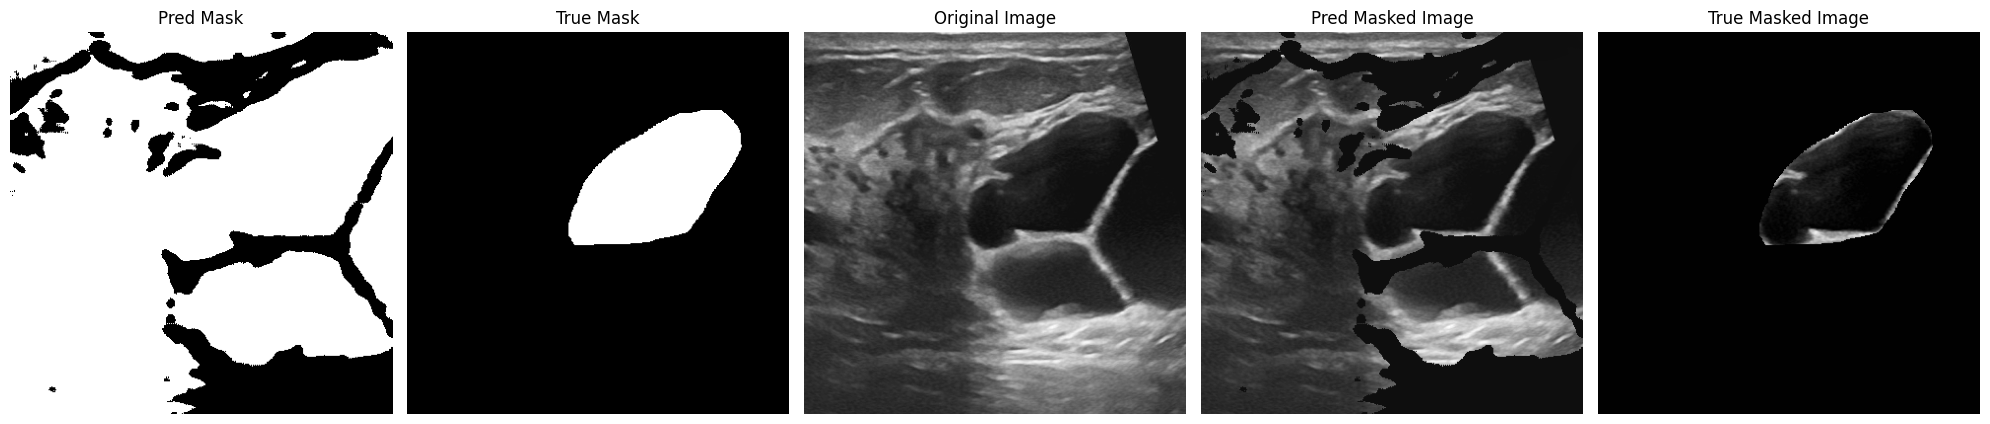

##########
##########
Pixel Error: 0.3003773093223572
Rand Error : 0.4203043458607145


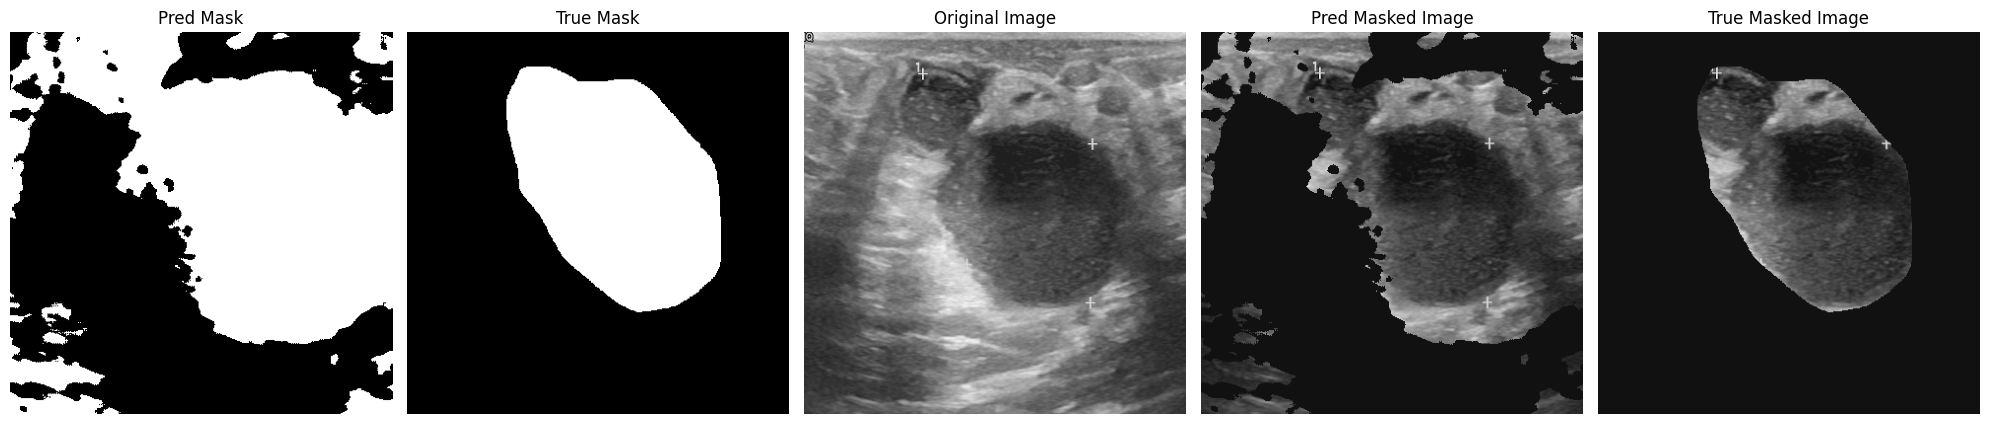

##########
##########
Pixel Error: 0.7953754663467407
Rand Error : 0.32550886298560633


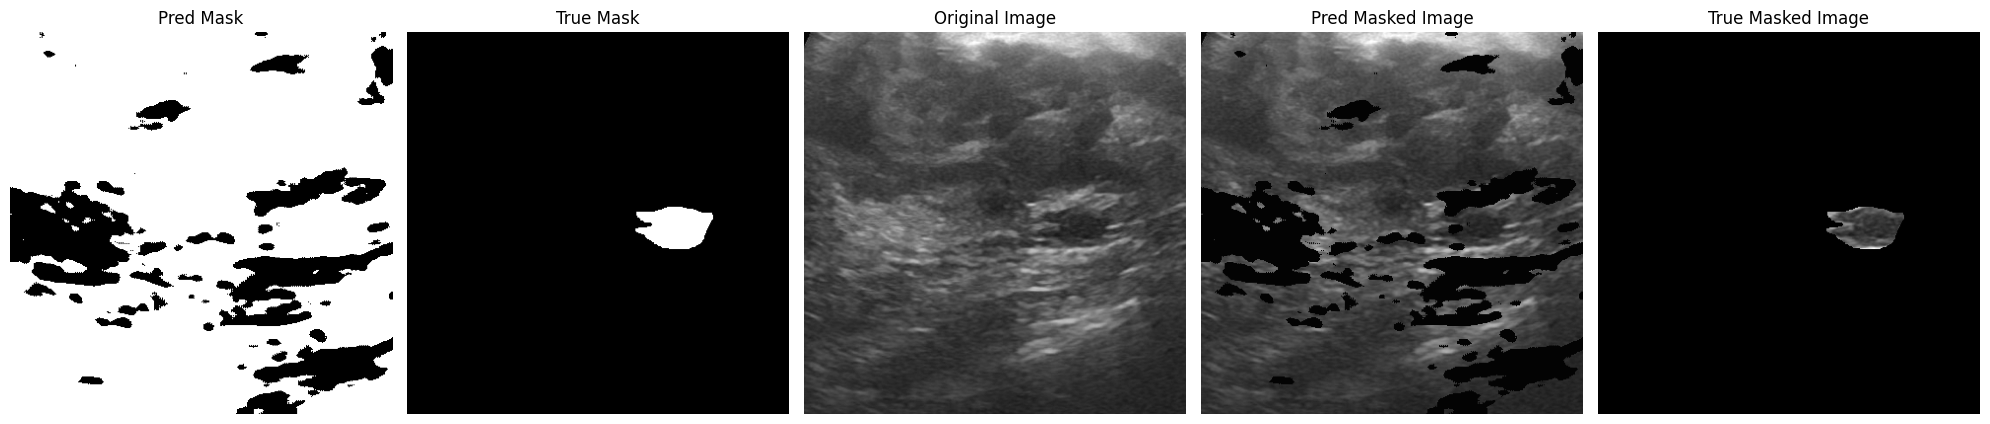

##########


In [17]:
c = 0
for data in test_loader:
    if c == 3: break
    print("#" * 10)
    plot_output(model, data)
    print("#" * 10)
    c += 1

In [18]:
avg_pixel_error = 0.0
avg_rand_error  = 0.0

for data in test_loader:
    errors = evaluate_error(model, data)
    avg_pixel_error += errors[0]
    avg_rand_error  += errors[1]

print(f"Average Pixel Error: {avg_pixel_error / len(test_loader)}")
print(f"Average Rand Error : {avg_rand_error  / len(test_loader)}")

Average Pixel Error: 0.5645619034767151
Average Rand Error : 0.43308232408451447


---